# 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from matplotlib.colors import LogNorm

sns.set_theme()

In [2]:
df = pd.read_csv('data/kill_match_stats_v2.csv')
df.head()

,killed_by,type,time,phase,dis,kx,ky,vx,vy
0,M16A4,AR,1035,2,194,4970,3126,4978,3320
1,AKM,AR,1422,4,7,4604,4147,4598,4144
2,AKM,AR,1210,3,8,4880,3472,4874,3477
3,SKS,DMR,1818,7,124,5011,4251,4930,4345
4,M416,AR,1766,7,85,4955,4298,4958,4383


# 3. Data Analyzing and Visualization
Ở phần này, nhóm sẽ thực hiện đặt một số câu hỏi có ý nghĩa và tìm câu trả lời từ dữ liệu

## 3.1. Câu hỏi 1
**Câu hỏi:** <span style = "color:red">Loại vũ khí nào hiệu quả nhất?</span>

**Ý nghĩa:** Khi tìm được loại vũ khí hiệu quả nhất, các player sẽ có sự lựa chọn loại vũ khí hợp lí cho chiến thuật của mình (vì mỗi player chỉ được trang bị 2 vũ khí chính, 1 `Handgun`, 1 `Melee` và 1 vũ khí ném (`Throwable`)), đặc biệt là với những player mới chơi, đang làm quen với game. Ở phần này nhóm chỉ phân tích độ hiệu quả của các loại vũ khí chính (trừ `Handgun`, `Melee`, `Throwable`, `Zone`, `Self`, `Vehicle`)

**Phân tích**: Để trả lời cho câu hỏi này, ta cần một thang đo độ hiệu quả. Khoảng cách và số lượng kill là 2 tiêu chí quan trọng để đánh giá độ hiệu quả của vũ khí. 
- Khoảng cách kill ngoài phụ thuộc vào vũ khí còn phụ thuộc vào trình độ của player cũng như vài yếu tố máy mắn khác, do đó ta sẽ sử dụng khoảng cách trung bình để đánh giá
- Số lượng kill ngoài cho biết loại vũ khí đó gây kill nhiều hay ít còn cho biết loại vũ khí nào được sử dụng nhiều hơn (nên gây kill nhiều hơn, vì nếu không gây kill hiệu quả thì các player sẽ đổi sang loại vũ khí hiệu quả hơn)
- Ngoài ra còn một số yếu tố khác như sát thương, độ giật. Tuy nhiên với dữ liệu nhóm đang có hiện tại, ta sẽ tạm phân tích dựa trên khoảng cách và số lượng kill

Vì vậy nhóm sẽ sử dụng heatmap để trực quan hóa độ hiệu quả của vũ khí như sau:
- Các dòng là các khoảng cách khác nhau:
    - 0m - 50m
    - 50m - 100m
    - 100 - 300m
    - 300 - 500m
    - Trên 500m
- Các cột là các loại vũ khí
- Mỗi cell giao của dòng với cột là số lượng kill của loại vũ khí ở khoảng cách tương ứng



In [3]:
cut_labels = ['0 - 50', '50 - 100', '100 - 300', '300 - 500', '> 500']
cut_bins = [0, 50, 100, 300, 500, 1000]
df['dis_bin'] = pd.cut(df['dis'], bins = cut_bins, labels = cut_labels)

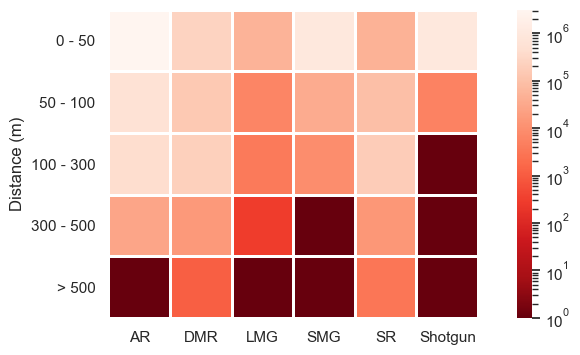

In [4]:
fig = plt.figure(figsize=(10, 4))

filter = ~df['type'].isin(['Zone', 'Self', 'Vehicle', 'Melee', 'Handgun', 'Throwable'])
data = df[filter][['type', 'dis_bin', 'killed_by']].groupby(['type', 'dis_bin']).count().reset_index()
data = pd.pivot(data, index = 'dis_bin', columns = 'type', values = 'killed_by')
ax = sns.heatmap(data + 1, cmap = 'Reds_r', linewidths = 1, norm = LogNorm())

ax.set_aspect('equal')
ax.set_ylabel('Distance (m)')
ax.set_xlabel('');

Trong heatmap trên, những cell càng sáng nghĩa là loại vũ khí đó càng gây được nhiều kill ở khoảng cách tương ứng
-	Đối với khoảng cách rất ngắn dưới 50m thì AR, SMG và Shotgun là các loại vũ khi hiệu quả
-	Khi khoảng cách tăng dần lên thì SMG và Shotgun dần mất lợi thế, lên đến mức 100 – 300m thì số lượng kill của SR và DMR đã vượt hẳn lên, đến mức trên 500m thì SR và DMR thống trị bảng kill
-	LMG dường như không lọt top hiệu quả nhất ở bất kì khoảng cách nào, chỉ nên lựa chọn khi không còn sự lựa chọn khác


## 3.2. Câu hỏi 2
**Câu hỏi:** <span style = "color:red">Những vị trí nào giao tranh nhiều ở khoảng đầu trận?</span>

**Ý nghĩa:** Trên bản đồ sẽ có những khu vực giao tranh nhộn nhịp hơn những khu vực khác, biết được các khu vực này giúp player chọn nơi nhảy dù, trú ẩn phù hợp với lối chơi của mình
- Ví dụ player thích thử thách, nâng cao kỹ năng, có thể chọn các khu vực đông đúng, giao tranh xảy ra liên tục
- Nếu người chơi chọn lối chơi sinh tồn có thể chọn các khu vực yên ắng, ít người

**Phân tích:** Câu hỏi này có thể trả lời dễ dàng bằng phân bố tọa độ 2 chiều đã làm ở `Data Understanding`

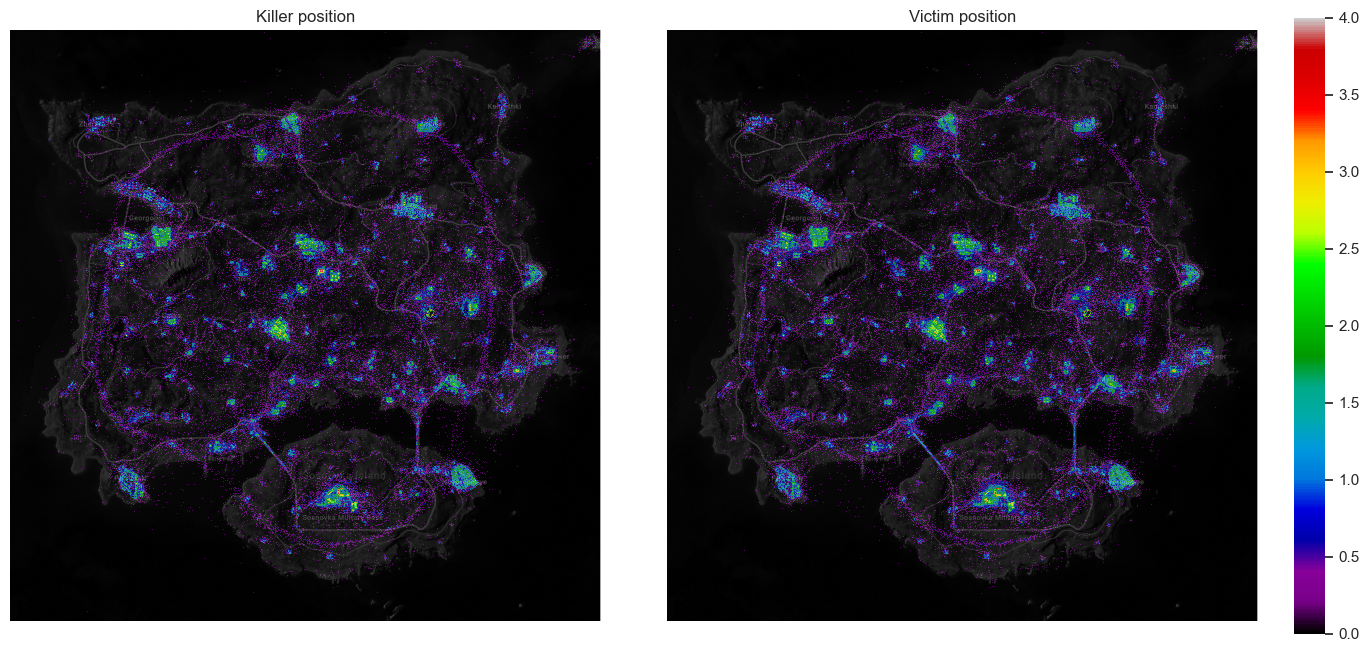

In [3]:
fig, axes = plt.subplots(ncols = 2, figsize = (18, 8), gridspec_kw={'width_ratios': [8, 10]})
fig.subplots_adjust(wspace = 0.1)
img = plt.imread('asset/map/ERANGEL.png')

number_of_bin = 1600

axes[0].imshow(img[::-1, :, 0], extent = [0, 1640, 0, 1640], alpha = 0.35, zorder = 3, cmap = 'gray')
axes[1].imshow(img[::-1, :, 0], extent = [0, 1640, 0, 1640], alpha = 0.35, zorder = 3, cmap = 'gray')

sns.heatmap(
    np.log10(plt.hist2d(
        df[df['time'] < 600]['ky'], 
        df[df['time'] < 600]['kx'], 
        bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1),
    cbar = False, cmap = 'nipy_spectral', ax = axes[0], vmin = 0, vmax = 4)

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title('Killer position')

sns.heatmap(
    np.log10(plt.hist2d(
        df[df['time'] < 600]['vy'], 
        df[df['time'] < 600]['vx'], 
        bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1), 
    cmap = 'nipy_spectral', ax = axes[1], vmin = 0, vmax = 4)

axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[1].set_title('Victim position')

plt.savefig('visualization break/heatmap.png', dpi = 1500, bbox_inches = 'tight')

Ta có thể các kiến trúc, các khu vực thành phố là những khu vực giao tranh gay gắt giai đoạn đầu trận

|   |   |   |   |
|---|---|---|---|
|__Pochinki__|__Rozhok & School__ | __Military Base__ | __Novorepnoy__ |
|<img src="visualization break/heatmap_1.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_2.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_3.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_4.png" style="height: 200px; width:200px;"/>|
|__Georgopol__|__Prison & Shelter__| __Yasnaya Polyana__| __Mylta__ |
|<img src="visualization break/heatmap_5.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_6.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_7.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_8.png" style="height: 200px; width:200px;"/>|
|__Serveny__|__Lipoka__|__Primosk__|__Mylta Power__|
|<img src="visualization break/heatmap_9.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_10.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_11.png" style="height: 200px; width:200px;"/>|<img src="visualization break/heatmap_12.png" style="height: 200px; width:200px;"/>|

## 3.3. Câu hỏi 3
**Câu hỏi:** <span style = "color:red">Những vị trí nào thuận lợi để  gây kill từ xa?</span>

**Ý nghĩa:** Trong đa số giai đoạn của trận đấu thì khả năng gây kill từ xa sẽ mang lại lợi thế rất lớn cho các player. SR và DMR là các vũ khí ưa chuộng dùng để gây kill từ xa. Biết được những vị trí thuận lợi để gây kill từ xa sẽ giúp các player có thêm những sự lựa chọn trong chiến lược của mình

**Phân tích:** Ta có thể làm tương tự cách biễu diễn heatmap số lượng kill

In [3]:
img = plt.imread('asset/map/ERANGEL.png')

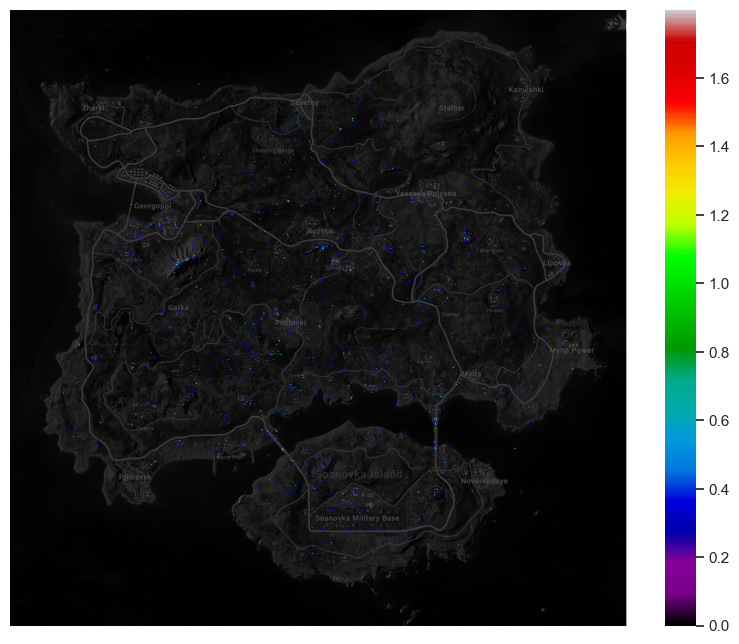

In [8]:
plt.figure(figsize=(10, 8))

number_of_bin = 1600
scale = 1640 * number_of_bin / 1600
plt.imshow(img[::-1, :, 0], extent = [0, scale, 0, scale], alpha = 0.35, zorder = 3, cmap = 'gray')

data = df[df['dis'] >= 400]

ax = sns.heatmap(
    np.log10(plt.hist2d(data['ky'], data['kx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1), cmap = 'nipy_spectral')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([]);

plt.savefig('distance_heatmap.png', dpi = 1200, bbox_inches = 'tight')

Quan sát bản đồ trên, ta có thể nhận thấy một số khu vực gây nhiều kill từ khoảng cách xa:

|   |   |   |   |   |
|---|---|---|---|---|
|Đồi gần `Pochinki`|Đồi và chung cư xung quanh `School` và `Rozhok`|Núi xương cá gần cảng `Georgopol`|Nhà trên vách gần `Mansion`|Núi cao giữa `Militari Base` và cảng `Novorepnoye`|
|<img src="visualization break/distance_heatmap_1.png" style="height: 200px; width:200px;"/>|<img src="visualization break/distance_heatmap_2.png" style="height: 200px; width:200px;"/>|<img src="visualization break/distance_heatmap_3.png" style="height: 200px; width:200px;"/>|<img src="visualization break/distance_heatmap_4.png" style="height: 200px; width:200px;"/>|<img src="visualization break/distance_heatmap_5.png" style="height: 200px; width:200px;"/>|


## 3.4. Câu hỏi 4
**Câu hỏi:** <span style = "color:red">Những vị trí gây kill thuận lợi gây kill từ xa có thực sự an toàn?</span>

**Ý nghĩa:** Tuy việc biết được các vị trí thuận lợi gây kill từ xa sẽ mang lại lợi thế nhưng các player cũng cần biết tình hình giao tranh tại các khu vực này?

**Phân tích:** Ta có thể biết được phần nào tình hình giao tranh dựa trên phân bố tọa độ của victim 2 chiều như đã làm ở phần trước. Bên cạnh đó ta cũng có thể nhìn sâu hơn, đây là các khu vực thuận lợi gây kill từ xa nên cũng có thể bị gây kill từ xa

In [83]:
img = plt.imread('asset/map/ERANGEL.png')

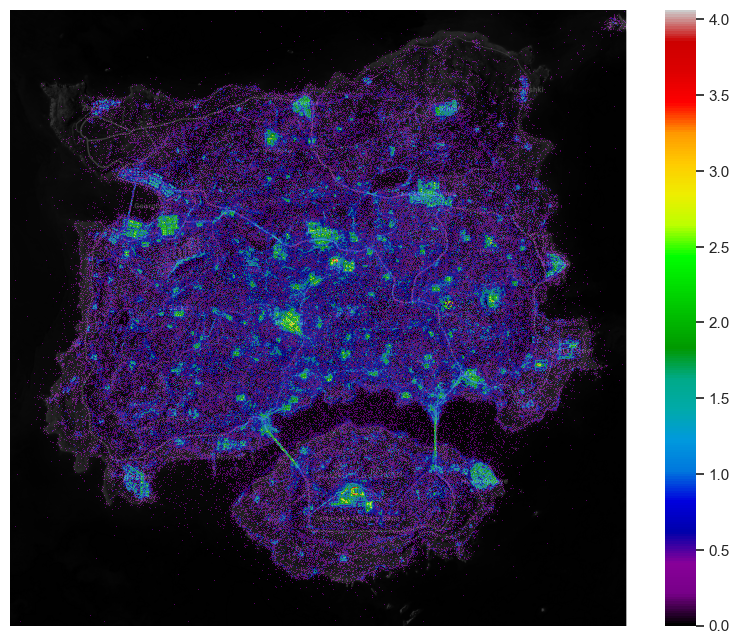

In [89]:
plt.figure(figsize=(10, 8))

number_of_bin = 1600
scale = 1640 * number_of_bin / 1600
plt.imshow(img[::-1, :, 0], extent = [0, scale, 0, scale], alpha = 0.35, zorder = 3, cmap = 'gray')

data = df

ax = sns.heatmap(
    np.log10(plt.hist2d(data['vy'], data['vx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1), cmap = 'nipy_spectral')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([]);

In [3]:
area_coords = {
    'Bridge1': [[3250, 3650], [5300, 5800]],
    'Bridge2': [[5400, 5600], [5300, 5800]],
    'FishBoneMt': [[2000, 2600], [3100, 3500]],
    'RozhokHill': [[3800, 4200], [3050, 3250]],
    'PochinkiHill': [[3200, 3600], [4300, 4540]],
    'MansionHill': [[5900, 5980], [2940, 3020]],
    'Apartment': [[4350, 4500], [3250, 3400]]
}

In [4]:
filter = (df['dis'] >= 400) & (
          ((df['vx'] >= area_coords['Bridge1'][0][0]) & 
           (df['vx'] <= area_coords['Bridge1'][0][1]) & 
           (df['vy'] >= area_coords['Bridge1'][1][0]) & 
           (df['vy'] <= area_coords['Bridge1'][1][1])) |
          ((df['vx'] >= area_coords['Bridge2'][0][0]) & 
           (df['vx'] <= area_coords['Bridge2'][0][1]) & 
           (df['vy'] >= area_coords['Bridge2'][1][0]) & 
           (df['vy'] <= area_coords['Bridge2'][1][1])) |
          ((df['vx'] >= area_coords['FishBoneMt'][0][0]) & 
           (df['vx'] <= area_coords['FishBoneMt'][0][1]) & 
           (df['vy'] >= area_coords['FishBoneMt'][1][0]) & 
           (df['vy'] <= area_coords['FishBoneMt'][1][1])) |
          ((df['vx'] >= area_coords['RozhokHill'][0][0]) & 
           (df['vx'] <= area_coords['RozhokHill'][0][1]) & 
           (df['vy'] >= area_coords['RozhokHill'][1][0]) & 
           (df['vy'] <= area_coords['RozhokHill'][1][1])) |
          ((df['vx'] >= area_coords['PochinkiHill'][0][0]) & 
           (df['vx'] <= area_coords['PochinkiHill'][0][1]) & 
           (df['vy'] >= area_coords['PochinkiHill'][1][0]) & 
           (df['vy'] <= area_coords['PochinkiHill'][1][1])) |
          ((df['vx'] >= area_coords['MansionHill'][0][0]) & 
           (df['vx'] <= area_coords['MansionHill'][0][1]) & 
           (df['vy'] >= area_coords['MansionHill'][1][0]) & 
           (df['vy'] <= area_coords['MansionHill'][1][1])) |
          ((df['vx'] >= area_coords['Apartment'][0][0]) & 
           (df['vx'] <= area_coords['Apartment'][0][1]) & 
           (df['vy'] >= area_coords['Apartment'][1][0]) & 
           (df['vy'] <= area_coords['Apartment'][1][1])) 
        )

data = df[filter][['kx', 'ky', 'vx', 'vy']] * 0.975

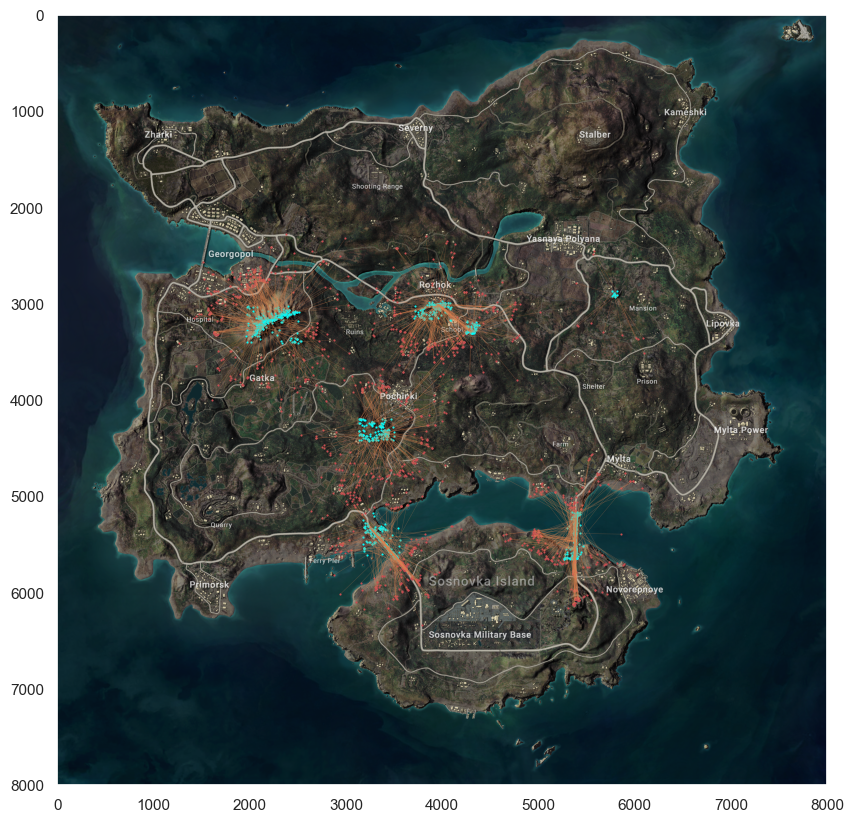

In [5]:
%matplotlib inline

start_time = time.time()

img = plt.imread('asset/map/ERANGEL.png')
plt.figure(figsize=(10, 10))

plt.imshow(img, extent = [0, 8000, 0, 8000], origin = 'lower')
ax = sns.scatterplot(x = data['kx'], y = data['ky'], alpha = 1, s = 2, edgecolor = None, color = 'r')
ax = sns.scatterplot(x = data['vx'], y = data['vy'], alpha = 1, s = 2, edgecolor = None, color = 'cyan')

for row in data.iterrows():
    ax.plot([row[1]['kx'], row[1]['vx']], [row[1]['ky'], row[1]['vy']], color = 'C1', alpha = 0.25, linewidth = 0.4)

ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
ax.grid(False)

plt.savefig('temp.png', dpi = 300, bbox_inches = 'tight')

## 3.5. Câu hỏi 5
**Câu hỏi:** Thời điểm thích hợp để qua cầu?

**Ý nghĩa:** Bản đồ gồm 2 đảo lớn và nhỏ, được nối bởi 2 cầu lớn. Trong trận đấu, các player thường phải đi qua cầu để sang đảo kia (để tìm kiếm trang bị, do vòng bluezone thu nhỏ). Tuy nhiên như đã trực quan hóa ở các phần trước, 2 khu vực cầu này là nơi tử trận của rất nhiều player, do đó ta cần cân nhắc thời điểm qua cầu phù hợp. Hoặc ngược lại, các player có thể chọn lối chơi `camp cầu`, thay vì đi qua cầu, các player sẽ dừng ở 2 đầu cầu để canh các player khác đi qua và bắn.

**Phân tích:** Ta có thể quan sát video đã encode ở cuối phần `Data Understanding` để trả lời cho câu hỏi này

<video width="640" height="480" controls>
  <source src="playzone.mp4" type="video/mp4">
</video>

Quan sát video trên, ta nhận thấy khoảng thời gian thuận lợi nhất để qua cầu là khoảng trước 800s, nghĩa là ở phase 1 và đầu phase 2. Tuy nhiên ở giai đoạn này vòng bluezone chưa thực sự thu về đảo lớn hay đảo nhỏ, do đó bên cạnh việc sử dụng dữ liệu để quyết định thời gian qua cầu, các player cần phải quyết đoán đưa ra phán đoán có nên qua cầu hay không. Ngược lại nếu các player muốn camp cầu có thể bắt đầu canh từ đầu phase 2 đến cuối phase 5 tùy vào tình hình vòng bluezone vì đây là khoảng thời gian nhiều player qua cầu nhiều (để né bluezone) và tử trận tại đây